In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
from functools import partial
from glm import glm, GLM, log_link, Gamma
from models import SEIR_hierarchical, plot_samples, plot_forecast, plot_R0
import util


def gen_covariates(places=None, num_places=5, intercept=False, drop_first=True):
    if places is None:
        places = [f'{i}' for i in range(num_places)]
    places = pd.DataFrame({'place': places})
    covariates = pd.get_dummies(places, drop_first=drop_first)
    if intercept:
        covariates['intercept'] = 1
    return covariates


Bad key "nbagg.transparent" on line 426 in
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an update

In [2]:
import models
models.SEIR_stochastic

<function models.SEIR_stochastic>

# Run Inference

In [3]:
#states = ['MA', 'NY', 'WA', 'AL']
states = ['MA', 'NY']
data, place_data = util.load_state_Xy(which=states)
data = data.join(place_data.drop(columns='state'), how='inner')

args = {
    'data': data,
    'place_data' : place_data,
    'use_rw': False,
    'rw_scale': 1e-2,
    'det_noise_scale' : 0.2
}

prob_model = SEIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=100,
            num_samples=100,
            num_chains=1)

mcmc.run(jax.random.PRNGKey(1), use_obs=True, **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()


# Prior samples for comparison
prior = Predictive(prob_model, posterior_samples = {}, num_samples = 100)
prior_samples = prior(PRNGKey(2), **args)

# Posterior predictive samples for visualization
args['rw_scale'] = 0 # set drift to zero for forecasting
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [8]:
util.write_summary('US_covariates', mcmc)
util.save_samples('US_covariates', prior_samples, mcmc_samples, post_pred_samples)

In [9]:
print("gamma", 1/mcmc_samples['I_duration'].mean(axis=0))
print("R0", mcmc_samples['R0'].mean(axis=0))
print("future", post_pred_samples['R0_future'].mean(axis=0))


gamma [0.3464801  0.37189826]
R0 [[3.1720471 3.1916845 3.1929438 3.2114496 3.1422884 3.043989  2.8601043
  2.8791342 2.8868668 2.9021463 2.9310255 2.9418378 3.0027227 3.7911875
  3.812908  3.866743  3.9161506 3.946541  3.9698458 3.911184  2.3683534
  2.3325617 2.2357802 2.1995196 2.1161597 2.063951  2.002806  1.9450969
  1.9285046 1.9070902 1.8889961 1.7992517 1.8053932 1.8105302 1.8117393
  1.3746085 1.3849001 1.400169  1.377096  1.3743753 1.4169884 1.401566
  1.3945823 1.4436171 1.3624917 1.4235996 1.3995278 1.4291694 1.3847905]
 [4.7473254 4.7597547 4.7051883 4.4703813 4.4937234 4.4915967 4.568578
  4.612752  4.66532   4.774122  4.8349023 4.8922715 4.8946023 4.9226923
  6.1805162 6.183546  3.5542111 3.5109382 3.4574018 3.4014502 3.3975034
  3.3474245 3.3126569 3.3031259 3.2971754 3.3343956 3.3254812 3.3625414
  3.373569  2.687618  2.6415446 2.6896884 2.6362207 2.6146927 2.6463132
  2.6072226 2.6235611 2.5971754 2.5985427 2.5845444 2.5817754 2.5405316
  2.5132647 2.484813  2.5041904 

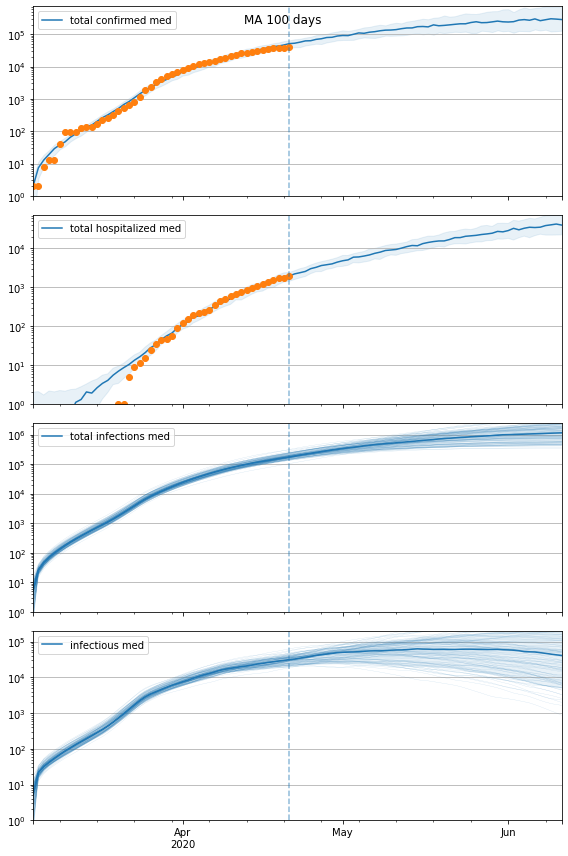

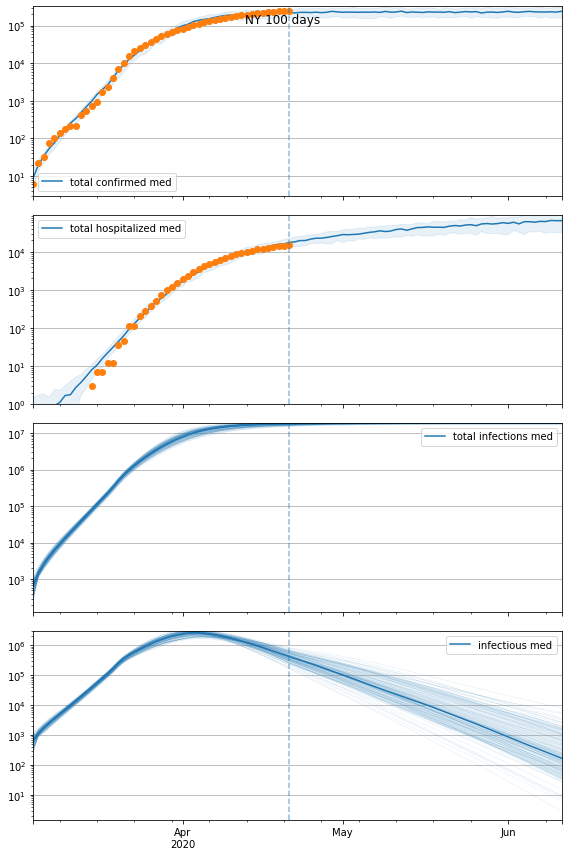

In [10]:
T = 100
scale = 'log'

places = data.index.unique(level=0)
start = data.index.unique(level=1).min()
num_places = len(places)

for i, place in zip(range(num_places), places):
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    shared_params = ['beta0_base', 'gamma_base', 'sigma_base', 'det_rate_base']
    place_samples = {k: v[:,i,...] for k, v in post_pred_samples.items() if not k in shared_params}
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    positive = data.loc[place].positive
    death = data.loc[place].death

    
    fig, ax = plot_forecast(place_samples, T, positive, t=t, scale=scale, death=death)

    #plot_samples(place_samples, plot_fields=['I'], ax=ax, t=t, T=T)
    #plt.plot(obs[i,:], 'o')

    name = place
    plt.suptitle(f'{name} {T} days ')
    plt.tight_layout()
    plt.show()

    
    